In [237]:
import numpy as np
import scipy
from scipy.integrate import solve_ivp
import scipy.integrate as integrate
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from scipy.interpolate import splev, splrep
from scipy.interpolate import InterpolatedUnivariateSpline

The critical temperature, TC:  130.957
Value of phi at TC:  172.135
The "zero" temperature, T0:  119.41201699999249
vC/TC:  1.3144419085291095


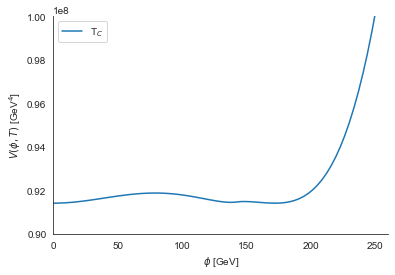

In [238]:
# T = 0 masses
mW0 = 80   #W boson mass
mZ0 = 91  #Z boson mass
mh0 = 125   #Higgs mass 
v0 = 246.0    #Higgs VEVss
mt0 = 173   #Top quark mass
lambdaH = mh0**2/(2*v0**2)  # lambda

mS2 = 600**2
lambdaHS = 4.1
muS2 = mS2 - lambdaHS*v0**2
mH2 = mh0**2/2
muH2 = -mH2

# Coefficients in eq (213)
D = (2*mW0**2 + mZ0**2 + 2*mt0**2)/(8*v0**2) 
E = (2*mW0**3 + mZ0**3)/(4*np.pi*v0**3) 
B = 3/(64*np.pi**2*v0**4)*(2*mW0**4 + mZ0**4 - 4*mt0**4)                
Tmin2 = (mh0**2 -8*B*v0**2)/(4*D)


def lTemp(T):
    lambdaTemp = - 3*(2*mW0**4*(np.log(mW0**2/T**2) - (5.4076- 1.5))\
                    + mZ0**4*(np.log(mZ0**2/T**2) - (5.4076 -1.5)) - 4*mt0**4*(np.log(mt0**2/T**2) - (2.6351 -1.5)))/(16*np.pi**2*v0**4)
    return lambdaH + lambdaTemp

phi = np.linspace(0, 350, 100)

def potentialQ(phi, T):
# Potential given by (213)
    return D*(T**2 - Tmin2)*phi**2 - E*T*np.abs(phi)**3 + lTemp(T)*phi**4/4
 
def potentialHiggs(phi, T):
    #Quantum and thermal loop corrections from Higgs 
    massHiggsField = 3*lambdaH*phi**2 - mH2
    thermal = (1/24)*massHiggsField*T**2 - (np.abs(massHiggsField)**(3/2)*np.sign(massHiggsField))*T/(12*np.pi) - 1/(64*np.pi**2)*massHiggsField**2*(np.log(mh0**2/T**2) - (5.4076 -1.5))
    quantum = 2*mh0**2*massHiggsField/(64*np.pi**2)
    return thermal + quantum

def potentialSinglet(phi, T):
    #Quantum and thermal loop corrections from Singlet
    thermal = (muS2 + lambdaHS*phi**2)*T**2/24 - (muS2 + lambdaHS*phi**2)**(3/2)*T/(12*np.pi) - 1/(64*np.pi**2)*(muS2 + lambdaHS*phi**2)**2*(np.log(mS2/T**2) - (5.4076 -1.5))
    quantum = 2*mS2*(muS2 + lambdaHS*phi**2)/(64*np.pi**2)
    return thermal + quantum

def potential(phi, T):
    sm = potentialQ(phi, T)
    h = potentialHiggs(phi, T)
    s = potentialSinglet(phi, T)
    return sm + h + s 


def dVdphi(phi, T, phiTest=None):
    # Derivative of the potential w.r.t phi
    pot = potential(phi, T)
    spl = InterpolatedUnivariateSpline(phi, pot)
    splder = spl.derivative()
    # If we want the derivative at a specific value provide phiTest and return the derivative at that point
    if isinstance(phiTest, float) or isinstance(phiTest, int):
        der = splder(phiTest)

    else:
        der = splder(phi)
    #print("dVdphi: ", der)
    return der

def dVdT(phi, T):
    # Derivative of the potential w.r.t T
    quiros = 2*D*T*phi**2 - E*phi**3
    massHiggsField = 3*lambdaH*phi**2 - mH2
    higgs = massHiggsField*T/12 - (np.abs(massHiggsField)**(3/2)*np.sign(massHiggsField))/(12*np.pi)
    massSingletField = muS2 + lambdaHS*phi**2
    singlet = massSingletField*T/12 - massSingletField**(3/2)/(12*np.pi)
    logTerms = (2*3*(2*mW0**4 + mZ0**4 - 4*mt0**4)/(16*np.pi**2*v0**4))/T + 2/(64*np.pi**2)*(massSingletField**2 + massHiggsField**2)/T
    derT = quiros + higgs + singlet + logTerms
    return derT

def equations(x, phi):
    # The critical temperature is when we have a degenerate minimum, i.e dVdphi = 0 and V = V(phi_F).
    # Hence define a system of non-linear equations with V - V(phi_F) = 0 and dV/dphi = 0 
    phiMin, T = x
    Vfalse = potential(0, T)
    V = potential(phiMin, T) - Vfalse
    dV = dVdphi(phi, T, phiTest=phiMin)
    return [V, dV]

# Use fsolve to find the roots of the system of equations
# Use the last point of the span of phi as an initial guess to find the right minimum, not phi_F = 0
phiAtMin, TC = fsolve(equations, [phi[70], 120.0], args=(phi,))
print('The critical temperature, TC: ', np.around(TC, 3))
print('Value of phi at TC: ', np.around(phiAtMin, 3))

def findT0forVEV(t):
    dV = dVdphi(phi, t, phiTest=v0)
    return dV

T0, = fsolve(findT0forVEV, TC)
print('The "zero" temperature, T0: ', T0)

def findPhiMin(phiMin):
    phiMin = phiMin[0]
    dV = dVdphi(phi, T, phiTest=phiMin)
    return dV

def findPhiForTN(phiN):
    phiN = phiN[0]
    dV = dVdphi(phi, TN, phiTest=phiN)
    return dV

def latentHeat(TN, phiN):
    rhoR = 106.75*np.pi**2*TN**4/30
    VEW = potential(phiN, TN)
    VF = potential(0, TN)
    dVEWdT = dVdT(phiN, TN)
    dVFdT = dVdT(0, TN)
    alpha = (VF - VEW + TN*(dVEWdT - dVFdT))/rhoR
    return alpha

# TN = 116.9
# phiN, = fsolve(findPhiForTN, phiAtMin)
# print('Phi at TN: ', phiN)
# print('vN/TN: ', phiN/TN)

potentialTC = potential(phi, TC)
# potentialTN = potential(phi, TN)
potentialT0 = potential(phi, T0)

# alpha = latentHeat(TN, phiN)
# print('Latent heat: ', alpha)

plt.figure()
plt.plot(phi, potentialTC, label=('T$_C$'))
#plt.plot(phi, potentialTN, label=('T$_N$'))
plt.legend()
plt.xlabel('$\phi$ [GeV]')
plt.ylabel('$V(\phi, T)$ [GeV$^4$]')
plt.ylim([9e7, 10e7])
plt.xlim([0,260])
sns.despine()

print('vC/TC: ', phiAtMin/TC)

In [239]:
def equationsBounce(r, y, temp, phi):
    """
    Function setting our equation system from the EOM of the bounce. 
    Turning equation of 2nd order ODE, to system of two 1st order ODEs.

        From: dphi^2/dr^2 + (alpha/r)*dphi/dr = dV/dphi

            introduce v = dphi/dr, s.t dv/dr = dphi^2/dr^2
            and then y = [phi, v], dy/dr = [dphi/dr, dv/dr]

        To: dy/dr = [dphi/dr, dv/dr] = [v, -(alpha/r)*dphi/dr + dV/dphi]                                              

    @param r: For T=0, r = sqrt(t^2 + x^2), for finite T r = r
           y: Array of phi and dphi/dr
           alpha: D-1 term, equals either 3 in 4D or 2 in 3D
    @return dydr: Array of dphi/dr and dphi^2/dr^2
    """
    # Pick out the values from y = [phi, v]
    h = y[0]
    v = y[1]        # v = dphi/dr

    #print("Phi: ", phi, "Temperature: ", temp)    
    # Finite-T
    alpha = 2

    # Define the derivatives
    dphidr = v
    dVdPhi = dVdphi(phi, temp, phiTest=h) 
    dvdr = - (alpha/r)*v + dVdPhi    # - (alpha/r)*v is the friction term, dVdphi(phi) the derivative of the potential (-)V(phi)
    #print("r: ", r, "dvdr", dvdr, "\n")
    
    # Set dy/dr = [dphi/dr, dv/dr]
    dydr = np.array([dphidr, dvdr])
    
    return dydr

In [240]:
def findAction(phiB, dPhiB, rad_span, temperature):
    potentialBounce = potential(phiB, temperature)
    potentialFalseVacuum = potential(0, temperature)
    integrand = rad_span**2*(0.5*dPhiB**2 + (potentialBounce - potentialFalseVacuum))
    integral = np.trapz(integrand, rad_span)
    S = integral*4*np.pi
    action = S/temperature
    return action

In [241]:
def shootingAction(r, phiTrueVacuum, phiFalseVacuum, undershoot, tol, temp):
    """
    Shooting method to find the bounce solution.

    EOM for the bounce:
    
        dphi^2/dr^2 = - (alpha/r)*dphi/dr + dV/dphi
    
    Like a point particle moving in a potential -V(phi) subject to a friction term.
    r acts as a time coordinate, and phi the spatial coordinate.

    There are two BCs for the bounce:
        1.) dphi/dr = 0 at r = 0 (no singularities in the origin, starting from rest)
        2.) phi(r) = phi_F at r = infinity  (the particle come at rest in the false vacuum phi_F when r=inf)

    We can turn this BVP to an IVP, we want to find the initial placement of the particle near the true vacuum phi_T that fulfills the BCs.
    We get the ICs:
        1.) dphi/dr = 0 at r = 0
        2.) phi(r) = phi_B at r = 0
    
    Where phi_B is the solution that fulfills BC 2.). 
    Setting dphi/dr = 0 and then an initial placement somewhere close to phi_T we get three different cases:
        a) The particle come at rest at phi_F when r = inf  (right solution, phi_B)
        b) The particle roll past phi_F (overshooting)
        c) The particle does not reach phi_F and experiences damped oscillations around the minimum (undershooting)

    When we have overshooting the initial placement of the particle is too close to phi_T and for undershooting
    it is too far from phi_T and needs to be closer. By trial and error, i.e iterate between over- and undershooting and 
    correct the intial placement until we find the right solution, case a), i.e the bounce solution phi_B.

    @param r: the "time" coordinate
           phiTrueVacuum: The value of phi at the true vacuum
           phiFalseVacuum: The value of phi at the false vacuum
           undershoot: sets the initial placement of the particle s.t we get an undershoot by phiTrueVacuum + undershoot.
           tol: Set tolerance for which we accept our numerical solution
    @return y_num: The numerical solution of the bounce

    """
    
    # Set tolerance for which we accept our numerical solution
    # and a maximum of iteration to abrupt the while loop 
    #tol = 1e-3
    max_iters = 100
    radius = 0


    # Set a lower and higher bound for our initial placement of the particle. 
    # Should be choosen s.t high gives an overshoot and low an undershoot.
    high = phiTrueVacuum
    low = phiTrueVacuum - undershoot
    
    # BC 1.), dphi/dr = 0 at r = 0
    dphidr0 = 0

    # Count of iterations
    count = 0

    # Parameter needed for solve_ivp, the first and last value of r
    xspan = (r[0], r[-1])


    while count <= max_iters:
        count = count + 1

        # Set the intial guess of the placement, phi0, as the mean between over- and undershoot              
        phi0 = np.mean([low, high])

        # Collect the two initial conditions
        f0 = [phi0, dphidr0]

        #print('phi0: ', phi0)
        # Solve our system of ODEs given as an IVP, evaluated at every point in r 
        sol = solve_ivp(equationsBounce, xspan, f0, method='LSODA', args = (temp, phi), dense_output = True)
        z = sol.sol(r)

        # The numerical solution from the solver
        y_num = z[0, :]
        #print(y_num[-1])

        # If the initial placement was right, i.e phi0 = phi_B we have found our solution and break
        # the while loop. check if value of the last point in our numerical solution is within tolerance to phi_F.
        if np.abs(y_num[-1] - phiFalseVacuum) <= tol:
            # Find the radius by finding the first value of r when phiB equals 0       
            index = 0
            for i in y_num:
                if np.abs(i - phiFalseVacuum) <= 1:
                    break
                else:
                    index += 1

            radius = r[index-1]         
            break
        
        # If the solution is not at the false vacuum we have either an over- or undershoot and 
        # we need to adjust our bounds. Depending on if phi_F is either to the righ or the left 
        # of phi_T the conditions for over- and undershoot will look different.

        # When phi_T is placed to the right of phi_F
        if phiTrueVacuum > phiFalseVacuum:
            # We get an overshoot if the last point of y_num is smaller than phi_F or if
            # it goes to +/- inf, we get the message 'Required step size is less than spacing between numbers.'
            # from solv_ivp if it has very high or low values since it stops working
            if sol.message == 'Required step size is less than spacing between numbers.'\
                or y_num[-1] < phiFalseVacuum or y_num[-1] > phiTrueVacuum or np.isnan(y_num[-1]):
                high = phi0
                #print('Overshoot \n')

            else:
                low = phi0
                #print('Undershoot \n')

    if radius == 0:
        radius = r[-1]

    #print(y_num[-1])
        
    R = np.linspace(r[0], radius, 100)
    bounce = sol.sol(R)

    # Get phi_B and dphi_B/dr needed for the Euclidean action
    dPhiB = bounce[1,:]
    phiB = bounce[0,:]

    return y_num, dPhiB, phiB, radius, R

In [242]:
actions = []
temperatures = []

Action:  557.7140049161939


(-1.0, 200.0)

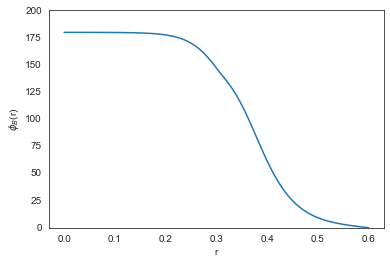

In [243]:
T = TC-0.4

phiMin, = fsolve(findPhiMin, phi[70])

r1 = np.linspace(0.00001, 0.6, 100)
phiB_numLong1, dPhiB_num, phiB_num, radius, R = shootingAction(r1, phiMin, 0, undershoot = 2, tol = 1e-1, temp = T)

action = findAction(phiB_num, dPhiB_num, R, T)
print("Action: ", action)

actions.append(action)
temperatures.append(T)

plt.figure()
plt.plot(r1, phiB_numLong1, label='T1')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 200])

Action:  389.85503294600034


(-1.0, 200.0)

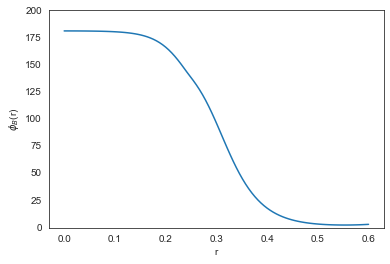

In [244]:
T = TC-0.5

phiMin, = fsolve(findPhiMin, phi[70])

r2 = np.linspace(0.00001, 0.6, 100)
phiB_numLong2, dPhiB_num, phiB_num, radius, R = shootingAction(r2, phiMin, 0, undershoot = 2, tol = 1e-1, temp = T)

action = findAction(phiB_num, dPhiB_num, R, T)
print("Action: ", action)

actions.append(action)
temperatures.append(T)

plt.figure()
plt.plot(r2, phiB_numLong2, label='T2')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 200])

Action:  292.0146498229763


(-1.0, 200.0)

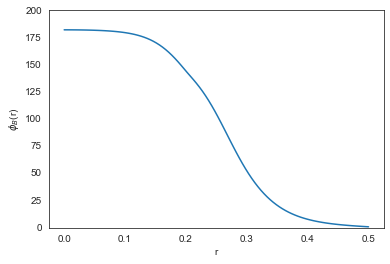

In [245]:
T = TC-0.6

phiMin, = fsolve(findPhiMin, phi[70])

r3 = np.linspace(0.00001, 0.5, 100)
phiB_numLong3, dPhiB_num, phiB_num, radius, R = shootingAction(r3, phiMin, 0, undershoot = 2, tol = 1e-1, temp = T)

action = findAction(phiB_num, dPhiB_num, R, T)
print("Action: ", action)

actions.append(action)
temperatures.append(T)

plt.figure()
plt.plot(r3, phiB_numLong3, label='T3')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 200])

Action:  229.5566547811188


(-1.0, 200.0)

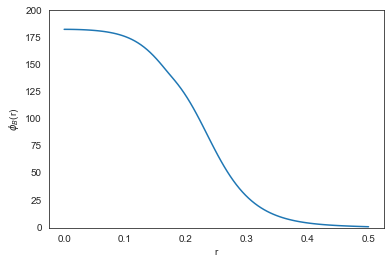

In [246]:
T = TC-0.7

phiMin, = fsolve(findPhiMin, phi[70])

r4 = np.linspace(0.00001, 0.5, 100)
phiB_numLong4, dPhiB_num, phiB_num, radius, R = shootingAction(r4, phiMin, 0, undershoot = 2, tol = 1e-1, temp = T)

action = findAction(phiB_num, dPhiB_num, R, T)
print("Action: ", action)

actions.append(action)
temperatures.append(T)

plt.figure()
plt.plot(r4, phiB_numLong4, label='T4')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 200])

Action:  196.7396870136731


(-1.0, 200.0)

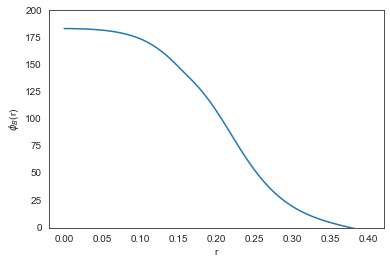

In [247]:
T = TC-0.8

phiMin, = fsolve(findPhiMin, phi[70])

r5 = np.linspace(0.00001, 0.4, 100)
phiB_numLong5, dPhiB_num, phiB_num, radius, R = shootingAction(r5, phiMin, 0, undershoot = 2, tol = 1e-1, temp = T)

action = findAction(phiB_num, dPhiB_num, R, T)
print("Action: ", action)

actions.append(action)
temperatures.append(T)

plt.figure()
plt.plot(r5, phiB_numLong5, label='T5')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 200])

Action:  169.9656823193822


(-1.0, 200.0)

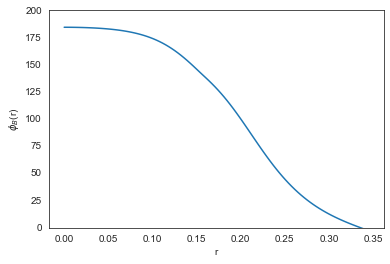

In [248]:
T = TC-0.9

phiMin, = fsolve(findPhiMin, phi[70])

r6 = np.linspace(0.00001, 0.345, 100)
phiB_numLong6, dPhiB_num, phiB_num, radius, R = shootingAction(r6, phiMin, 0, undershoot = 2, tol = 1e-1, temp = T)

action = findAction(phiB_num, dPhiB_num, R, T)
print("Action: ", action)

actions.append(action)
temperatures.append(T)

plt.figure()
plt.plot(r6, phiB_numLong6, label='T6')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 200])

Action:  153.79694037855884


(-1.0, 200.0)

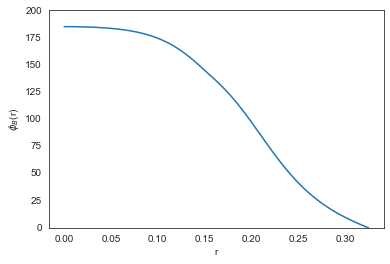

In [249]:
T = TC-0.95

phiMin, = fsolve(findPhiMin, phi[70])

r7 = np.linspace(0.00001, 0.325, 100)
phiB_numLong7, dPhiB_num, phiB_num, radius, R = shootingAction(r7, phiMin, 0, undershoot = 2, tol = 1e-1, temp = T)

action = findAction(phiB_num, dPhiB_num, R, T)
print("Action: ", action)

actions.append(action)
temperatures.append(T)

plt.figure()
plt.plot(r7, phiB_numLong7, label='T7')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 200])

Action:  147.84924287722762


(-1.0, 200.0)

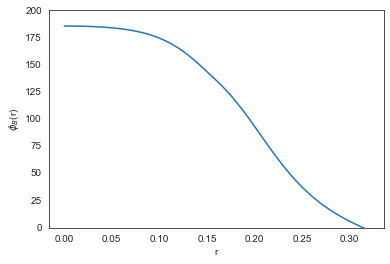

In [250]:
T = TC-1

phiMin, = fsolve(findPhiMin, phi[70])

r8 = np.linspace(0.00001, 0.32, 100)
phiB_numLong8, dPhiB_num, phiB_num, radius, R = shootingAction(r8, phiMin, 0, undershoot = 2, tol = 1e-1, temp = T)

action = findAction(phiB_num, dPhiB_num, R, T)
print("Action: ", action)

actions.append(action)
temperatures.append(T)

plt.figure()
plt.plot(r8, phiB_numLong8, label='T8')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 200])

Action:  141.23980861425213


(-1.0, 200.0)

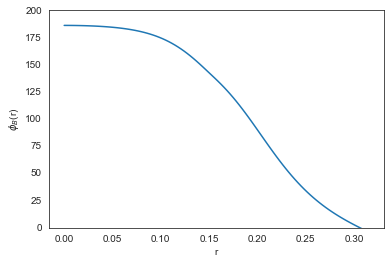

In [251]:
T = TC-1.05

phiMin, = fsolve(findPhiMin, phi[70])

r9 = np.linspace(0.00001, 0.315, 100)
phiB_numLong9, dPhiB_num, phiB_num, radius, R = shootingAction(r9, phiMin, 0, undershoot = 2, tol = 1e-1, temp = T)

action = findAction(phiB_num, dPhiB_num, R, T)
print("Action: ", action)

actions.append(action)
temperatures.append(T)

plt.figure()
plt.plot(r9, phiB_numLong9, label='T9')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 200])

Action:  135.56108365810672


(-1.0, 200.0)

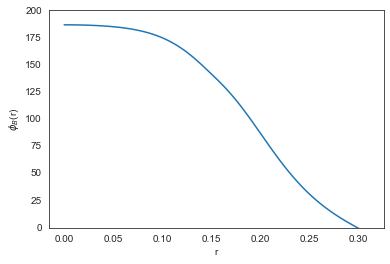

In [252]:
T = TC-1.1

phiMin, = fsolve(findPhiMin, phi[70])

r10 = np.linspace(0.00001, 0.31, 100)
phiB_numLong10, dPhiB_num, phiB_num, radius, R = shootingAction(r10, phiMin, 0, undershoot = 2, tol = 1e-1, temp = T)

action = findAction(phiB_num, dPhiB_num, R, T)
print("Action: ", action)

actions.append(action)
temperatures.append(T)

plt.figure()
plt.plot(r10, phiB_numLong10, label='T10')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 200])

Action:  131.03413384620742


(-1.0, 200.0)

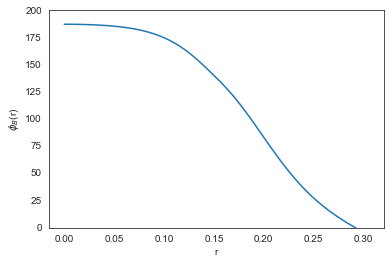

In [253]:
T = TC-1.15

phiMin, = fsolve(findPhiMin, phi[70])

r11 = np.linspace(0.00001, 0.305, 100)
phiB_numLong11, dPhiB_num, phiB_num, radius, R = shootingAction(r11, phiMin, 0, undershoot = 2, tol = 1e-1, temp = T)

action = findAction(phiB_num, dPhiB_num, R, T)
print("Action: ", action)

actions.append(action)
temperatures.append(T)

plt.figure()
plt.plot(r11, phiB_numLong11, label='T11')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 200])

Action:  126.49754770601693


(-1.0, 200.0)

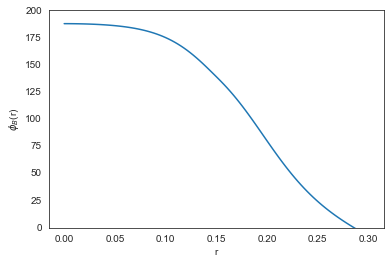

In [254]:
T = TC-1.2

phiMin, = fsolve(findPhiMin, phi[70])

r12 = np.linspace(0.00001, 0.3, 100)
phiB_numLong12, dPhiB_num, phiB_num, radius, R = shootingAction(r12, phiMin, 0, undershoot = 2, tol = 1e-1, temp = T)

action = findAction(phiB_num, dPhiB_num, R, T)
print("Action: ", action)

actions.append(action)
temperatures.append(T)

plt.figure()
plt.plot(r12, phiB_numLong12, label='T12')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 200])

TC =  130.96
TN =  129.9
beta/H:  16292.0
Latent heat:  0.026


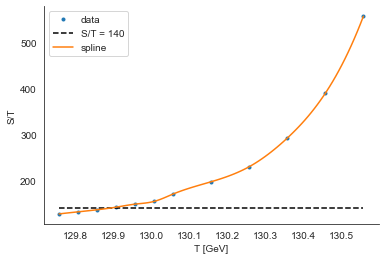

In [255]:
from scipy.interpolate import splev, splrep
from scipy.interpolate import InterpolatedUnivariateSpline

actions = np.array(actions)

plt.figure()
plt.plot(temperatures, actions, '.', label='data')
plt.xlabel('T [GeV]')
plt.ylabel('S/T')

nuc = np.linspace(140,140,100)
x = np.flip(temperatures)
y = np.flip(actions)
spl = InterpolatedUnivariateSpline(x, y)
x2 = np.linspace(x[0], x[-1], 100)
y2 = spl(x2)
plt.plot(x2, nuc, 'k--', label='S/T = 140')
plt.plot(x2, y2, label='spline')
print('TC = ', np.around(TC, 2))
#plt.title('Critical temperature = 119.37 GeV')
plt.legend()
sns.despine()

def difference(x):
    return np.abs(spl(x) - 140)

TN, = fsolve(difference, TC-2)


phiN, = fsolve(findPhiForTN, phiAtMin)

derivative = spl.derivative()
betaH = TN*derivative(TN)
alpha = latentHeat(TN, phiN)
print('TN = ', np.around(TN,2))
print('beta/H: ', np.around(betaH))
print('Latent heat: ', np.around(alpha,3))